## Обработка и анализ train_main.parquet 

### 1. Анализ метаданных в словаре.

    Цель: Отобрать ключевые признаки еще до обработки, чтобы сократить объем данных.

    Смотрим на описание, ищем технические метаданные, дубли по смыслу  

##### Гипотиза - мы отсеим большую часть на этапах очистки от пропусков , дублей , констант . 

1. На данном этапе смотрим полверхностно на очевидные метаданные
2. Вернемся к анализу метаданных в словарях, когда сократим и обработаем признаки на поздних этапах обработки

In [217]:
from comet_ml import start
from comet_ml import Experiment
from comet_ml import ExistingExperiment
experiment = ExistingExperiment(
    api_key='AwHbhSRbA9WGz71iTwGB4oPZU',
    project_name='dsc-2025-3-distribution-task',
    workspace='andreyshveduke',
    experiment_key="c7caecde6311477fa15f59e3573d2071" 
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/andreyshveduke/dsc-2025-3-distribution-task/c7caecde6311477fa15f59e3573d2071



In [218]:
# библиотеки Python 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from catboost import Pool, CatBoostRegressor

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection


from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import optuna
import json



In [219]:
# загружаем данные с признаками

train = pd.read_parquet('data/train_main.parquet')

dict_main = pd.read_csv('data/dictionary_main.csv')



In [220]:
# Логируем describe() как CSV
#experiment.log_table("train_main_stats.csv", train.describe().to_csv())

In [221]:
# Общая информация об основных признаках

def display_main_info(df, df_dict):

    display(df.head(n = 5))
    display(df.tail())
    display(df.info())
    display(df.dtypes.value_counts())
    
    categorical_features_list = cat_features(df)
    
    display(categorical_features_list)
    
    display_info_about_cat(categorical_features_list, df_dict)
    
    # отдельно смотрим на категории описаний, вдруг чего ненужное углядим
    
    display(df_dict['category'].value_counts())
    display(df_dict['feature_group'].value_counts())
    display(df_dict['modeling_type'].value_counts())

# функция возвращает список категориальных признаков
def cat_features(df):
    features = df.columns

    categorical_features = df[features].select_dtypes(include=['object']).columns

    
    for feature in categorical_features:
        df[feature] = df[feature].astype(str)

    #categorical_features_indices = np.where(df.dtypes == 'object')[0]

    return (categorical_features)

def display_info_about_cat(cf_list, df_dict):
    with pd.option_context('display.max_colwidth', 150):
        display(df_dict[df_dict['feature'].isin(cf_list)])

In [222]:
# зпускаем наши функцию просмотра инфы об датасете

display_main_info(train, dict_main)


,user_id,app_children_cnt,app_dependent_cnt,app_family_cnt,app_income_app,app_real_estate_ind,app_vehicle_ind,avg_dep_avg_balance_12month_amt,avg_dep_avg_balance_12month_amt_term,avg_dep_avg_balance_12month_amt_term_savings,...,savings_sum_oms_debet_3m,savings_sum_oms_debet_6m,savings_sum_oms_debet_9m,savings_sum_oms_debet_12m,savings_service_model_cd,savings_pension_flg,savings_deposit_flg,savings_safe_acc_flg,savings_broker_flg,savings_oms_flg
0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4027.373535,...,34.613216,0.000000,4.310414,75.214180,Массовый,0,0,1,0,0
1,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.237672,0.000000,0.000000,0.000000,Массовый,0,0,1,0,0
2,12,0.0,0.0,0.0,105372.960938,0.0,0.0,315208.781250,NaN,274816.375000,...,0.000000,53.134129,90.025238,0.000000,Массовый,0,0,1,0,0
3,13,1.0,0.0,3.0,0.000000,0.0,0.0,43187.953125,NaN,5277.233887,...,0.000000,22.276114,82.070015,117.386795,Массовый,0,0,1,0,0
4,15,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,33.072178,Массовый,0,0,1,0,0


,user_id,app_children_cnt,app_dependent_cnt,app_family_cnt,app_income_app,app_real_estate_ind,app_vehicle_ind,avg_dep_avg_balance_12month_amt,avg_dep_avg_balance_12month_amt_term,avg_dep_avg_balance_12month_amt_term_savings,...,savings_sum_oms_debet_3m,savings_sum_oms_debet_6m,savings_sum_oms_debet_9m,savings_sum_oms_debet_12m,savings_service_model_cd,savings_pension_flg,savings_deposit_flg,savings_safe_acc_flg,savings_broker_flg,savings_oms_flg
213340,999984,0.0,0.0,2.0,NaN,0.0,0.0,275394.156250,44389.640625,118400.195312,...,0.000000,0.000000,0.000000,0.000000,Массовый,0,1,1,1,0
213341,999985,0.0,0.0,0.0,71090.882812,0.0,0.0,18996.976562,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,Массовый,1,0,1,0,0
213342,999987,NaN,NaN,NaN,NaN,NaN,NaN,42967.109375,NaN,22946.318359,...,31.734211,50.059757,61.065586,59.969765,Массовый,0,0,1,0,0
213343,999997,0.0,0.0,2.0,89401.125000,0.0,0.0,9688.291016,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,Массовый,0,0,1,0,0
213344,999999,NaN,NaN,NaN,NaN,NaN,NaN,13202.808594,NaN,NaN,...,37.077259,0.000000,0.000000,127.146080,Массовый,0,0,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213345 entries, 0 to 213344
Columns: 280 entries, user_id to savings_oms_flg
dtypes: float64(266), int32(6), object(8)
memory usage: 450.9+ MB


None

float64    266
object       8
int32        6
Name: count, dtype: int64

Index(['brand_nm', 'current_work_experience_nm', 'gender_nm', 'industry_nm',
       'marital_status_nm', 'salary_flg', 'total_work_experience_nm',
       'savings_service_model_cd'],
      dtype='object')

,feature,modeling_type,description,category,feature_group
33,brand_nm,categorical,Бренд авто,Соцдем,Депозиты/Зарплаты/Анкеты
47,current_work_experience_nm,categorical,Стаж на последнем месте работы,Соцдем,Депозиты/Зарплаты/Анкеты
57,gender_nm,categorical,Пол,Соцдем,Депозиты/Зарплаты/Анкеты
63,industry_nm,categorical,Сфера деятельности,Соцдем,Депозиты/Зарплаты/Анкеты
64,marital_status_nm,categorical,Семейное положение,Соцдем,Депозиты/Зарплаты/Анкеты
93,salary_flg,categorical,Флаг зарплатного клиента,Зарплатные начисления,Депозиты/Зарплаты/Анкеты
122,total_work_experience_nm,categorical,Общий стаж работы,Соцдем,Депозиты/Зарплаты/Анкеты
274,savings_service_model_cd,categorical,Категория клиента (Прайм/Привилегия/Массовый) на отчетную дату,Модели сбережений,NaN


category
Модели сбережений             104
Депозиты и счета               93
Переводы, доходы и расходы     46
Соцдем                         20
Зарплатные начисления          16
ключ                            1
Name: count, dtype: int64

feature_group
Депозиты/Зарплаты/Анкеты    129
Зарплата                     46
DEPOSIT                      33
SAVE ACCOUNT                 23
BROKER                       23
OMS                          23
Name: count, dtype: int64

modeling_type
numerical      255
categorical     24
ключ             1
Name: count, dtype: int64

In [223]:
# посмотрим на категории 
with pd.option_context('display.max_colwidth', 150):
    display(dict_main[dict_main['modeling_type'] == 'categorical'])

,feature,modeling_type,description,category,feature_group
5,app_real_estate_ind,categorical,Наличие недвижимости,Соцдем,Депозиты/Зарплаты/Анкеты
6,app_vehicle_ind,categorical,Наличие авто,Соцдем,Депозиты/Зарплаты/Анкеты
33,brand_nm,categorical,Бренд авто,Соцдем,Депозиты/Зарплаты/Анкеты
47,current_work_experience_nm,categorical,Стаж на последнем месте работы,Соцдем,Депозиты/Зарплаты/Анкеты
57,gender_nm,categorical,Пол,Соцдем,Депозиты/Зарплаты/Анкеты
63,industry_nm,categorical,Сфера деятельности,Соцдем,Депозиты/Зарплаты/Анкеты
64,marital_status_nm,categorical,Семейное положение,Соцдем,Депозиты/Зарплаты/Анкеты
93,salary_flg,categorical,Флаг зарплатного клиента,Зарплатные начисления,Депозиты/Зарплаты/Анкеты
122,total_work_experience_nm,categorical,Общий стаж работы,Соцдем,Депозиты/Зарплаты/Анкеты
123,used_car_flg,categorical,Флаг БУ авто,Соцдем,Депозиты/Зарплаты/Анкеты


In [224]:
# рассмотрим категории , которые в основном Df не имеют таких признаков , т е определяются как int64

categorical_features_list = cat_features(train)

cat_indict = dict_main[dict_main['modeling_type'] == 'categorical']['feature'].tolist()

cat_indict = [x for x in cat_indict if x not in categorical_features_list]

display(train[cat_indict].head( n = 10))

for column in cat_indict:
    display(train[column].value_counts())



,app_real_estate_ind,app_vehicle_ind,used_car_flg,vehicle_counrty_type_nm,zp_flag_2month,zp_flag_3month,zp_flag_6month,zp_flag_9month,zp_flag_12month,zp_flag_18month,zp_flag_24month,savings_pension_flg,savings_deposit_flg,savings_safe_acc_flg,savings_broker_flg,savings_oms_flg
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0
2,0.0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0,0,1,0,0
3,0.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,1,0,0
4,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0
5,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,0,1,0,0
6,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0
7,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0
8,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0


app_real_estate_ind
0.0    134492
1.0       794
Name: count, dtype: int64

app_vehicle_ind
0.0    114667
1.0     20619
Name: count, dtype: int64

used_car_flg
0.0    134751
1.0       535
Name: count, dtype: int64

vehicle_counrty_type_nm
 0.0    4453
-1.0    2123
 1.0      30
Name: count, dtype: int64

zp_flag_2month
1.0    66420
Name: count, dtype: int64

zp_flag_3month
1.0    69424
Name: count, dtype: int64

zp_flag_6month
1.0    75383
Name: count, dtype: int64

zp_flag_9month
1.0    79368
Name: count, dtype: int64

zp_flag_12month
1.0    82255
Name: count, dtype: int64

zp_flag_18month
1.0    88116
Name: count, dtype: int64

zp_flag_24month
1.0    93029
Name: count, dtype: int64

savings_pension_flg
0    185428
1     27917
Name: count, dtype: int64

savings_deposit_flg
0    174448
1     38897
Name: count, dtype: int64

savings_safe_acc_flg
1    213345
Name: count, dtype: int64

savings_broker_flg
0    176949
1     36396
Name: count, dtype: int64

savings_oms_flg
0    211134
1      2211
Name: count, dtype: int64

**Первичный анализ мета-данных показал что, категориальных признаков больше, необходимо учесть это при обучении модели**

### 2. Анализ данных и первичная очистка

- **Пропуски**:
- **Важно**: CatBoost сам обрабатывает пропуски, но лучше явно контролировать процесс.  
  - Числовые признаки: на данном этапе удалим признаки с порогом пропусков более 80% и заполним пропуск явно (-999) . **Возможно вернуться к этому этапу после первого круга отсева признаков**
  - Категориальные: создаем отдельную категорию `"MISSING"` ,явно указываем CatBoost на категориальные признаки
  - Категориальные: редкие категории (например, <1% данных) объединить в `"OTHER"`. 
  

In [225]:
# функция удаляет признаки с пропусками более threshold % данных 
def drop_null(df, threshold):
    cols_null_percent = df.isnull().mean()*100
    cols_with_null = cols_null_percent[cols_null_percent > threshold].sort_values( ascending = False)
    display(cols_with_null)
    drop_list = cols_with_null.index.tolist()
    return drop_list




In [226]:
# удалим столбцы с пропусками с заданным порогом
drop_list = drop_null(train, 70)

train = train.drop(columns = drop_list)

vehicle_counrty_type_nm                      96.903607
max_amt_foreign_cur_5y                       94.277344
max_amt_dep_6m                               85.554384
min_amt_term_g1y                             84.525065
max_amt_dep_act                              82.061450
avg_sum_nws2op                               82.035670
dep_avg_term_active                          81.947081
avg_dep_avg_balance_fact_1month_amt_term     81.284305
avg_dep_avg_balance_fact_3month_amt_term     80.044060
avg_dep_avg_balance_fact_6month_amt_term     78.879280
avg_dep_avg_balance_fact_12month_amt_term    76.159741
dtype: float64

In [227]:
# заполним пропуски в категориальных признаках

# 1. создадим список всех кат признаков используя мета данные в словарях

def full_catlist(df, df_dict):
    categorical_features_df = list(cat_features(df))
    categorical_features_dfdict = df_dict[(df_dict['modeling_type'] == 'categorical') & (~df_dict['feature'].isin(drop_list)) ]['feature'].tolist()
    categorical_features_full = list(set(categorical_features_df + categorical_features_dfdict))
    return categorical_features_full

categorical_features_full = full_catlist(train, dict_main)

categorical_features_full

['brand_nm',
 'salary_flg',
 'total_work_experience_nm',
 'zp_flag_9month',
 'savings_service_model_cd',
 'savings_safe_acc_flg',
 'current_work_experience_nm',
 'app_real_estate_ind',
 'zp_flag_18month',
 'gender_nm',
 'marital_status_nm',
 'zp_flag_2month',
 'zp_flag_12month',
 'savings_broker_flg',
 'zp_flag_3month',
 'zp_flag_6month',
 'used_car_flg',
 'zp_flag_24month',
 'savings_deposit_flg',
 'industry_nm',
 'savings_oms_flg',
 'savings_pension_flg',
 'app_vehicle_ind']

In [228]:
# 2. Заполним пропуски в категориях , там есть и пустые и NaN 
def fill_cat_nan(df, cat_list):
    df[cat_list] = df[cat_list].fillna("MISSING")
    df[cat_list] = df[cat_list].replace('', 'MISSING')
    return df

train = fill_cat_nan(train, categorical_features_full)


In [229]:
display(train[categorical_features_full])

,brand_nm,salary_flg,total_work_experience_nm,zp_flag_9month,savings_service_model_cd,savings_safe_acc_flg,current_work_experience_nm,app_real_estate_ind,zp_flag_18month,gender_nm,...,savings_broker_flg,zp_flag_3month,zp_flag_6month,used_car_flg,zp_flag_24month,savings_deposit_flg,industry_nm,savings_oms_flg,savings_pension_flg,app_vehicle_ind
0,MISSING,MISSING,MISSING,MISSING,Массовый,1,MISSING,MISSING,MISSING,Ж,...,0,MISSING,MISSING,MISSING,MISSING,0,MISSING,0,0,MISSING
1,MISSING,MISSING,MISSING,MISSING,Массовый,1,MISSING,MISSING,MISSING,Ж,...,0,MISSING,MISSING,MISSING,MISSING,0,MISSING,0,0,MISSING
2,MISSING,SZP,10+,1.0,Массовый,1,12м+,0.0,1.0,Ж,...,0,MISSING,1.0,0.0,1.0,0,Строительство,0,0,0.0
3,MISSING,IZP,10+,1.0,Массовый,1,12м+,0.0,1.0,Ж,...,0,1.0,1.0,0.0,1.0,0,Услуги,0,0,0.0
4,MISSING,OTHER,MISSING,MISSING,Массовый,1,0-3м,0.0,MISSING,Ж,...,0,MISSING,MISSING,0.0,MISSING,0,Оптовая и розничная торговля,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213340,MISSING,SZP,10+,1.0,Массовый,1,12м+,0.0,1.0,Ж,...,1,1.0,1.0,0.0,1.0,1,Оптовая и розничная торговля,0,0,0.0
213341,MISSING,OTHER,10+,MISSING,Массовый,1,12м+,0.0,MISSING,Ж,...,0,MISSING,MISSING,0.0,MISSING,0,Услуги,0,1,0.0
213342,MISSING,SZP,MISSING,1.0,Массовый,1,MISSING,MISSING,1.0,М,...,0,1.0,1.0,MISSING,1.0,0,MISSING,0,0,MISSING
213343,MISSING,SZP,10+,MISSING,Массовый,1,12м+,0.0,MISSING,М,...,0,MISSING,MISSING,0.0,1.0,0,Другие отрасли,0,0,0.0


In [230]:
# посмотрим на категории , это важно потому что дальше мы удалим редкие , но без предварительного анализа это может навредить

for column in categorical_features_full:
    display(train[column].value_counts())

brand_nm
MISSING      210323
KIA             398
HYUNDAI         310
NISSAN          173
BMW             144
              ...  
MINI              1
ШЕВРОЛЕ           1
LANDROVER         1
VOLGA             1
БЕЛАВА            1
Name: count, Length: 76, dtype: int64

salary_flg
MISSING    88536
SZP        83193
OTHER      22267
IZP        19349
Name: count, dtype: int64

total_work_experience_nm
MISSING    119004
10+         72429
3-10        17756
1-3          3669
0-1           487
Name: count, dtype: int64

zp_flag_9month
MISSING    133977
1.0         79368
Name: count, dtype: int64

savings_service_model_cd
Массовый      181877
Привилегия     28728
VIP             2740
Name: count, dtype: int64

savings_safe_acc_flg
1    213345
Name: count, dtype: int64

current_work_experience_nm
12м+       97151
MISSING    96615
0-3м       10147
6-12м       7760
3-6м        1672
Name: count, dtype: int64

app_real_estate_ind
0.0        134492
MISSING     78059
1.0           794
Name: count, dtype: int64

zp_flag_18month
MISSING    125229
1.0         88116
Name: count, dtype: int64

gender_nm
Ж    117761
М     95503
?        81
Name: count, dtype: int64

marital_status_nm
MISSING              107213
Женат/Замужем         62758
Холост/Не замужем     38257
В разводе              1761
Гражданский брак       1585
Вдовец/Вдова           1492
Не указан               279
Name: count, dtype: int64

zp_flag_2month
MISSING    146925
1.0         66420
Name: count, dtype: int64

zp_flag_12month
MISSING    131090
1.0         82255
Name: count, dtype: int64

savings_broker_flg
0    176949
1     36396
Name: count, dtype: int64

zp_flag_3month
MISSING    143921
1.0         69424
Name: count, dtype: int64

zp_flag_6month
MISSING    137962
1.0         75383
Name: count, dtype: int64

used_car_flg
0.0        134751
MISSING     78059
1.0           535
Name: count, dtype: int64

zp_flag_24month
MISSING    120316
1.0         93029
Name: count, dtype: int64

savings_deposit_flg
0    174448
1     38897
Name: count, dtype: int64

industry_nm
MISSING                                                       96401
Другие отрасли                                                35995
Услуги                                                        11228
Оптовая и розничная торговля                                  11037
Образование                                                    6818
Транспорт                                                      6260
Медицина                                                       6129
Финансы, банки, страхование                                    6122
Строительство                                                  5693
Промышленность и машиностроение                                5683
Органы власти и управления                                     4328
Информационные технологии/коммуникации                         3991
Армия                                                          3275
Отсутствует                                                    2817
Наука и культура                    

savings_oms_flg
0    211134
1      2211
Name: count, dtype: int64

savings_pension_flg
0    185428
1     27917
Name: count, dtype: int64

app_vehicle_ind
0.0        114667
MISSING     78059
1.0         20619
Name: count, dtype: int64

In [231]:
# заменим редкие категории на other

def replace_rare_categories(df, categorical_features, threshold=0.001, replace_with='OTHER', exception = []):
    """
    Заменяет редкие категории в указанных признаках на 'OTHER'.
    
    Параметры:
    - df: DataFrame, исходные данные
    - categorical_features: список категориальных признаков
    - threshold: порог частоты (меньше которого категория считается редкой)
    - replace_with: значение, на которое заменяем редкие категории (по умолчанию 'OTHER')
    - exception : заложим возможность исключения каких то категорий
    
    Возвращает:
    - Модифицированный DataFrame с замененными редкими категориями
    """
    df_processed = df.copy()
    
    for feature in categorical_features:
        # проверяем на исключение:
        if feature in exception:
            continue
        # Рассчитываем частоту каждой категории
        freq = df_processed[feature].value_counts(normalize=True)
        
        # Находим категории, которые встречаются реже порога
        rare_categories = freq[freq < threshold].index
        
        # Заменяем редкие категории на 'OTHER'
        df_processed[feature] = df_processed[feature].replace(rare_categories, replace_with)
    
    return df_processed

In [232]:
# c таблицей train из за уникальности категории brand_nm принял решение отработать ее отдельно
# напишем функцию оброаботки категорий учитывая нюансы , возможно пригодиться для других дата сетов задачи
train_copy = replace_rare_categories(train, categorical_features_full, threshold=0.001, replace_with='OTHER', exception = ['industry_nm', 'gender_nm', 'marital_status_nm', 'brand_nm'])

In [233]:
# отдельно обработаем brand_nm

brand_counts = train_copy['brand_nm'].value_counts()

popular_brands = brand_counts[brand_counts > 2].index

train_copy['brand_nm'] = train_copy['brand_nm'].apply(lambda x: x if x in popular_brands else 'OTHER')

with pd.option_context('display.max_rows', None):
    display(train_copy['brand_nm'].value_counts())

brand_nm
MISSING          210323
KIA                 398
HYUNDAI             310
NISSAN              173
BMW                 144
MITSUBISHI          138
VOLKSWAGEN          138
LADA                137
FORD                127
TOYOTA              126
AUDI                109
SKODA               106
MAZDA                99
SUZUKI               84
CHEVROLET            84
RENAULT              76
VOLVO                74
LAND ROVER           74
MERCEDES             73
LEXUS                45
OPEL                 42
OTHER                37
HONDA                37
ВАЗ                  30
LAND-ROVER           29
SUBARU               28
MERCEDES-BENZ        25
PEUGEOT              24
INFINITI             23
UAZ                  23
ГАЗ                  21
PORSCHE              19
JAGUAR               19
SSANGYONG            19
JEEP                 16
CITROEN              15
ДОПОБОРУД            13
DAEWOO               13
FIAT                 12
VW                   10
CADILLAC              9
RAVON  

In [234]:
train = train_copy

In [235]:
# посмотрим на категории повторно

#for column in categorical_features_full:
#   display(train_copy[column].value_counts())

In [236]:
# заполним пропуски в числовых признаках

#train= train.fillna(-999)

In [237]:
#train

In [238]:
#отсечем категории и index_id

def only_numeric(df, categorical_features_full):
    new_df = df.drop(columns = categorical_features_full + ['user_id'])
    return new_df

copy_df =  only_numeric(train, categorical_features_full)
numeric_cols = copy_df.columns.tolist()

In [239]:
# зафиксируем кол-во пропусков для контроля


total_missing = train[numeric_cols].isnull().sum().sum()
total_missing

11676628

In [240]:
# проверим результат 
cols_null_percent = train.isnull().mean()*100
cols_null_percent

user_id                  0.000000
app_children_cnt        50.222410
app_dependent_cnt       56.985634
app_family_cnt          54.006890
app_income_app          53.745342
                          ...    
savings_pension_flg      0.000000
savings_deposit_flg      0.000000
savings_safe_acc_flg     0.000000
savings_broker_flg       0.000000
savings_oms_flg          0.000000
Length: 269, dtype: float64

- **Удаление константных признаков**:  


- **Проверим на полные дубликаты**

- **Выбросы**:  
  - Для числовых признаков: использовать **IQR** или **z-score** для обнаружения и замены на граничные значения.  
 

In [241]:
# ищем удаляем константные признаки 

def del_constant_columns(df):
    constant_cols = [col for col in df.columns if df[col].nunique() == 1]
    display(constant_cols)
    if constant_cols:
        df_copy = df.drop(columns = constant_cols)
    else:
        df_copy = df
    return constant_cols, df_copy


In [242]:
# удаляем константные признаки

constant_cols, train_copy = del_constant_columns(train)

# обновляем списки numeric_cols, categorical_features_full !!!!!!!

categorical_features_full = [ cat for cat in categorical_features_full if cat not in constant_cols]

copy_df =  only_numeric(train_copy, categorical_features_full)
numeric_cols = copy_df.columns.tolist()

['savings_safe_acc_flg']

In [243]:
train = train_copy

In [244]:
# дубликаты

def find_all_duplicates(df):
    """
    Находит все полные дубликаты в DataFrame и возвращает их в виде нового DataFrame.
    
    Параметры:
    - df: Исходный DataFrame
    
    Возвращает:
    - DataFrame только с дублирующимися строками (со всеми вхождениями)
    - None, если дубликатов нет
    """
    # Находим все дубликаты (включая все вхождения)
    duplicates = df[df.duplicated(subset = None, keep = False)]
    
    if duplicates.empty:
        print("Дубликатов не найдено")
        return None
    
    
    # Добавляем столбец с количеством дубликатов для каждой группы

    dup_counts = df.groupby(df.columns.tolist()).size().reset_index(name='duplicate_count')
    duplicates = duplicates.merge(dup_counts, on=df.columns.tolist())
    
    return duplicates

In [245]:
find_all_duplicates(train)

Дубликатов не найдено


In [246]:
#train_noid = train.drop(columns = 'user_id')
#find_all_duplicates(train_noid)

#### Методы IQR и Изолирующий лес не применимы на соревнованиях , можем только посмотреть на качество модели на валидации

In [247]:
# выбросы
#отсечем категории и index_id

def only_numeric(df, categorical_features_full):
    new_df = df.drop(columns = categorical_features_full + ['user_id'])
    return new_df

copy_df =  only_numeric(train, categorical_features_full)
numeric_cols = copy_df.columns.tolist()
len(numeric_cols)

245

In [248]:
#1. Простые случаи (для IQR)

# Автоматическая проверка "простоты" признака
def is_simple_feature(series, skew_threshold=2, kurtosis_threshold=5):
    
    clean_series = series[~pd.isna(series)]
    
    # Если после фильтрации осталось мало данных, считаем признак "не простым"
    if len(clean_series) < 10:  # Минимальное число точек для анализа
        return False
    
    skewness = clean_series.skew()
    kurt = clean_series.kurtosis()
    return abs(skewness) < skew_threshold and abs(kurt) < kurtosis_threshold


simple_cols = [col for col in numeric_cols if is_simple_feature(copy_df[col])]

len(simple_cols)

12

In [249]:
 # 3. Признаки с аномальным IQR-соотношением
def detect_complex_features(df, cols, iqr_coef=2.5):
    complex_features = []
    for col in cols:
        # Исключаем пропущенные значения из анализа
        clean_data = df[col][~pd.isna(df[col])]
        # Если после фильтрации осталось мало данных, пропускаем признак
        if len(clean_data) < 10:
            continue
        q1, q3 = clean_data.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - iqr_coef*iqr, q3 + iqr_coef*iqr
        outliers_ratio = ((clean_data < lower) | (clean_data > upper)).mean()
        if outliers_ratio > 0.05:  # Если >5% данных — выбросы по IQR
            complex_features.append(col)
    return complex_features
delta_cols = list(set(numeric_cols) - set(simple_cols))

complex_cols = detect_complex_features(copy_df, delta_cols)
len(complex_cols)

126

##### Попробуем применить  RobustScaler на признаках которые обноружили IQR и Изолес 

In [250]:
from sklearn.preprocessing import RobustScaler

# Создаем копию данных
train_scaled = train.copy()

# Инициализируем RobustScaler (без центрирования для сохранения разреженности)
scaler = RobustScaler(with_centering=False)

# Масштабируем каждую колонку отдельно
for col in set(train_scaled.columns.tolist()) & set(simple_cols + complex_cols):
    # Получаем колонку и создаем маску не-NaN значений
    col_data = train_scaled[col].values.reshape(-1, 1)
    mask = ~pd.isna(col_data).flatten()  # Маска для не-NaN значений
    
    # Масштабируем только не-NaN значения
    if sum(mask) > 0:  # Если есть что масштабировать
        train_scaled.loc[mask, col] = scaler.fit_transform(col_data[mask]).flatten()


# 2. Применяем те же преобразования к тесту НЕ ЗАБУДЬ
#test[simple_cols + complex_cols] = scaler.transform(test[simple_cols + complex_cols])

In [251]:
train = train_scaled

### 3. Feature Selection

- **Коррелирующие признаки**:  
  - Рассчитайте матрицу корреляций и удалите один из признаков с корреляцией >0.95.  
  ```python
  corr_matrix = df.corr().abs()
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
  collinear_cols = [col for col in upper.columns if any(upper[col] > 0.95)]

- **Важность признаков**:  
  - Обучите CatBoost с `plot=True` для оценки важности (можно использовать `get_feature_importance()`).  
  - Удалите признаки с нулевой важностью. 

In [252]:
# кореляция 
def corr_cols (df, numeric_cols):

    corr_matrix = df[numeric_cols].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    collinear_cols = [col for col in upper.columns if any(upper[col] > 0.95)]
    
    return collinear_cols
collinear_cols = corr_cols(train, numeric_cols )
display(len(collinear_cols))

128

In [253]:
# удалим колинеарные 

train = train.drop(columns = collinear_cols)

train.shape

(213345, 140)

In [254]:
# закрузка целевой переменной для обучения тренировочных данных

y_train_df = pd.read_csv('data/train_target.csv')


display(y_train_df.shape)
display(y_train_df['target'].describe())




(213345, 2)

count    2.133450e+05
mean     2.210490e+05
std      9.894988e+05
min     -7.100000e-01
25%      0.000000e+00
50%      3.174000e+01
75%      1.000027e+05
max      1.015605e+08
Name: target, dtype: float64

Целевая переменная точно требует ее преобразовать. Посмотрим как она выглядит после log1p:

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 7.9324e+04, 2.4010e+03, 1.8540e+03,
        1.6580e+03, 1.5990e+03, 1.6980e+03, 1.6060e+03, 2.0930e+03,
        9.6700e+02, 6.9300e+02, 5.1800e+02, 6.2800e+02, 6.1900e+02,
        5.1300e+02, 4.9400e+02, 5.1800e+02, 4.9600e+02, 4.6800e+02,
        4.2000e+02, 4.8500e+02, 4.8700e+02, 4.6100e+02, 4.3900e+02,
        5.1000e+02, 5.8100e+02, 5.5100e+02, 4.7900e+02, 4.2300e+02,
        4.1500e+02, 3.8100e+02, 4.2700e+02, 4.7100e+02, 4.7100e+02,
        5.1700e+02, 4.8700e+02, 4.9600e+02, 4.9600e+02, 5.4000e+02,
        5.5600e+02, 5.0600e+02, 6.6200e+02, 6.5800e+02, 6.4400e+02,
        6.4300e+02, 7.5300e+02, 6.8000e+02, 7.1800e+02, 9.2700e+02,
        7.6400e+02, 6.7000e+02, 5.5300e+02, 6.1300e+02, 5.3900e+02,
        6.2100e+02, 6.3300e+02, 6.0300e+02, 6.4500e+02, 5.8500e+02,
        6.5700e+02, 6.6900e+02, 6.1400e+02, 6.90

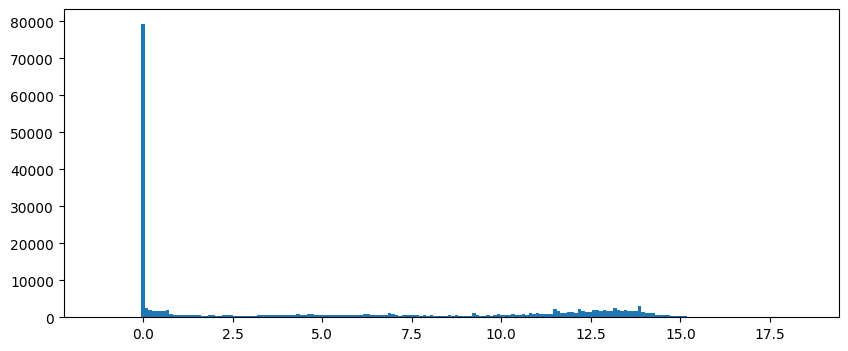

In [255]:
plt.figure(figsize=(10,4))

plt.hist(np.log1p(y_train_df['target']), bins = 200)
#experiment.log_figure(figure=plt)

В распределении очень много нулей, так что стоит смотреть чуть уже:

(array([4.093e+03, 1.894e+03, 1.661e+03, 1.464e+03, 1.522e+03, 1.484e+03,
        1.607e+03, 1.851e+03, 8.640e+02, 6.060e+02, 5.020e+02, 5.730e+02,
        5.870e+02, 4.960e+02, 4.720e+02, 4.890e+02, 4.520e+02, 4.850e+02,
        3.710e+02, 4.290e+02, 4.540e+02, 4.450e+02, 4.400e+02, 4.030e+02,
        4.890e+02, 5.620e+02, 5.140e+02, 4.530e+02, 3.950e+02, 3.860e+02,
        3.620e+02, 3.860e+02, 4.380e+02, 4.440e+02, 4.440e+02, 4.880e+02,
        4.390e+02, 4.840e+02, 4.710e+02, 5.000e+02, 5.180e+02, 4.770e+02,
        6.230e+02, 6.220e+02, 6.140e+02, 5.860e+02, 6.730e+02, 6.890e+02,
        6.170e+02, 7.860e+02, 8.150e+02, 6.920e+02, 5.690e+02, 5.340e+02,
        5.590e+02, 5.130e+02, 5.710e+02, 6.060e+02, 5.750e+02, 5.950e+02,
        5.430e+02, 6.120e+02, 6.210e+02, 6.180e+02, 5.690e+02, 6.480e+02,
        6.320e+02, 7.580e+02, 6.540e+02, 6.850e+02, 6.630e+02, 6.140e+02,
        6.660e+02, 6.610e+02, 9.580e+02, 9.070e+02, 6.120e+02, 4.720e+02,
        4.630e+02, 5.270e+02, 5.260e+0

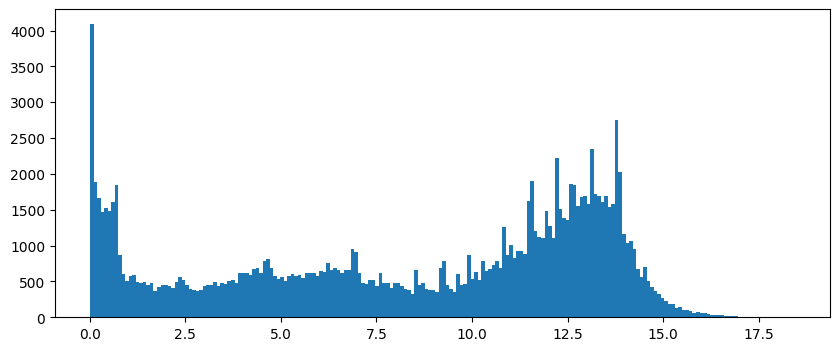

In [256]:
plt.figure(figsize=(10,4))

plt.hist(np.log1p(y_train_df.loc[y_train_df['target'] > 0, 'target']), bins = 200)
#experiment.log_figure(figure=plt)

Распределение выглядит очень похожим на смесь:
- Есть клиенты с значениями около нуля
- Есть компонента смеси с центром в районе 6, то есть ~400 (np.exp(6) - 1)
- Есть компонента справа, с центров в районе 13, то есть ~440,000
- И есть еще клиенты с ровно 0, которых мы убрали с графика

In [257]:
# обозначим номера столбцов у categorical_features_full


train[categorical_features_full] = train[categorical_features_full].astype(str)
categorical_features_indices = [train.columns.get_loc(col) for col in categorical_features_full]
categorical_features_indices

[9,
 45,
 60,
 80,
 135,
 21,
 5,
 85,
 29,
 35,
 70,
 83,
 138,
 74,
 77,
 61,
 88,
 137,
 34,
 139,
 136,
 6]

In [258]:
# Обучим catboost и уберем признаки с нулевой важностью

def is_important_features(df, y_train_df, categorical_features_full, learning_rate=0.05, iterations=200):
    
    df = df.drop(columns = 'user_id')
    
    # Создаем Pool для CatBoost
    train_pool = Pool(df, label= np.log1p(y_train_df['target']), cat_features = categorical_features_full )

    # Инициализируем и обучаем модель
    model = CatBoostRegressor(
        iterations = iterations,
        learning_rate = learning_rate,
        depth=8,
        l2_leaf_reg = 4.87774,
        loss_function='RMSE',
        random_seed=42,
        nan_mode='Min',
        verbose = 100,
        task_type = 'GPU'
        )
    model.fit(train_pool)

    # Получаем важность признаков
    feature_importance = model.get_feature_importance()
    feature_names = df.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    return importance_df
    
importance_df = is_important_features(train, y_train_df, categorical_features_full, learning_rate = 0.02, iterations=1000)

print("Ранжирование признаков по важности:")
print(importance_df.to_string(index=False))


0:	learn: 5.4808573	total: 147ms	remaining: 2m 27s
100:	learn: 2.3142909	total: 13.9s	remaining: 2m 4s
200:	learn: 2.1510558	total: 27.8s	remaining: 1m 50s
300:	learn: 2.1227105	total: 41.5s	remaining: 1m 36s
400:	learn: 2.1045808	total: 55.1s	remaining: 1m 22s
500:	learn: 2.0907066	total: 1m 8s	remaining: 1m 8s
600:	learn: 2.0791911	total: 1m 22s	remaining: 54.6s
700:	learn: 2.0687008	total: 1m 36s	remaining: 41s
800:	learn: 2.0587290	total: 1m 49s	remaining: 27.3s
900:	learn: 2.0485226	total: 2m 3s	remaining: 13.6s
999:	learn: 2.0402669	total: 2m 16s	remaining: 0us
Ранжирование признаков по важности:
                             Feature  Importance
                  savings_sum_sa_now   28.187135
                   savings_sum_sa_1m   24.265167
             savings_sum_sa_debet_1m    8.637258
min_max_dep_balance_amt_term_savings    5.310993
            savings_sum_sa_credit_1m    3.864841
                   savings_sum_sa_2m    3.108761
          sum_dep_expense_1month_amt    2.62442

In [259]:
#ненулевая важность
mask = importance_df['Importance'] > 0 
selected_features = importance_df[mask]
print("\nОтобранные признаки (ненулевая важность):", selected_features['Feature'].tolist())


Отобранные признаки (ненулевая важность): ['savings_sum_sa_now', 'savings_sum_sa_1m', 'savings_sum_sa_debet_1m', 'min_max_dep_balance_amt_term_savings', 'savings_sum_sa_credit_1m', 'savings_sum_sa_2m', 'sum_dep_expense_1month_amt', 'sum_dep_expense_3month_amt', 'savings_sum_sa_3m', 'savings_sum_sa_debet_3m', 'savings_avg_sa_3m', 'max_max_dep_income_amt_term_savings', 'avg_dep_avg_balance_12month_amt', 'savings_sum_sa_debet_6m', 'zp_first_month_12m', 'savings_sum_sa_6m', 'savings_sum_sa_debet_9m', 'zp_first_month_24m', 'savings_sum_sa_9m', 'zp_first_month_6m', 'savings_avg_sa_6m', 'sum_amount_zp_1m', 'customer_age', 'savings_sum_sa_12m', 'savings_sum_sa_credit_3m', 'savings_sum_sa_credit_12m', 'min_max_dep_balance_amt', 'savings_sum_sa_credit_6m', 'max_dep_avg_balance_12month_amt', 'gender_nm', 'sum_dep_expense_12month_amt', 'sum_dep_expense_6month_amt', 'zp_last_month', 'savings_sum_sa_credit_9m', 'max_amt_dep_5y', 'savings_sum_dep_3m', 'zp_payments_1month', 'dep_first_close_m', 'dep_

In [260]:
selected_features

,Feature,Importance
101,savings_sum_sa_now,28.187135
102,savings_sum_sa_1m,24.265167
115,savings_sum_sa_debet_1m,8.637258
43,min_max_dep_balance_amt_term_savings,5.310993
110,savings_sum_sa_credit_1m,3.864841
...,...,...
1,app_dependent_cnt,0.004465
8,brand_nm,0.003024
60,used_car_flg,0.002862
4,app_real_estate_ind,0.002016


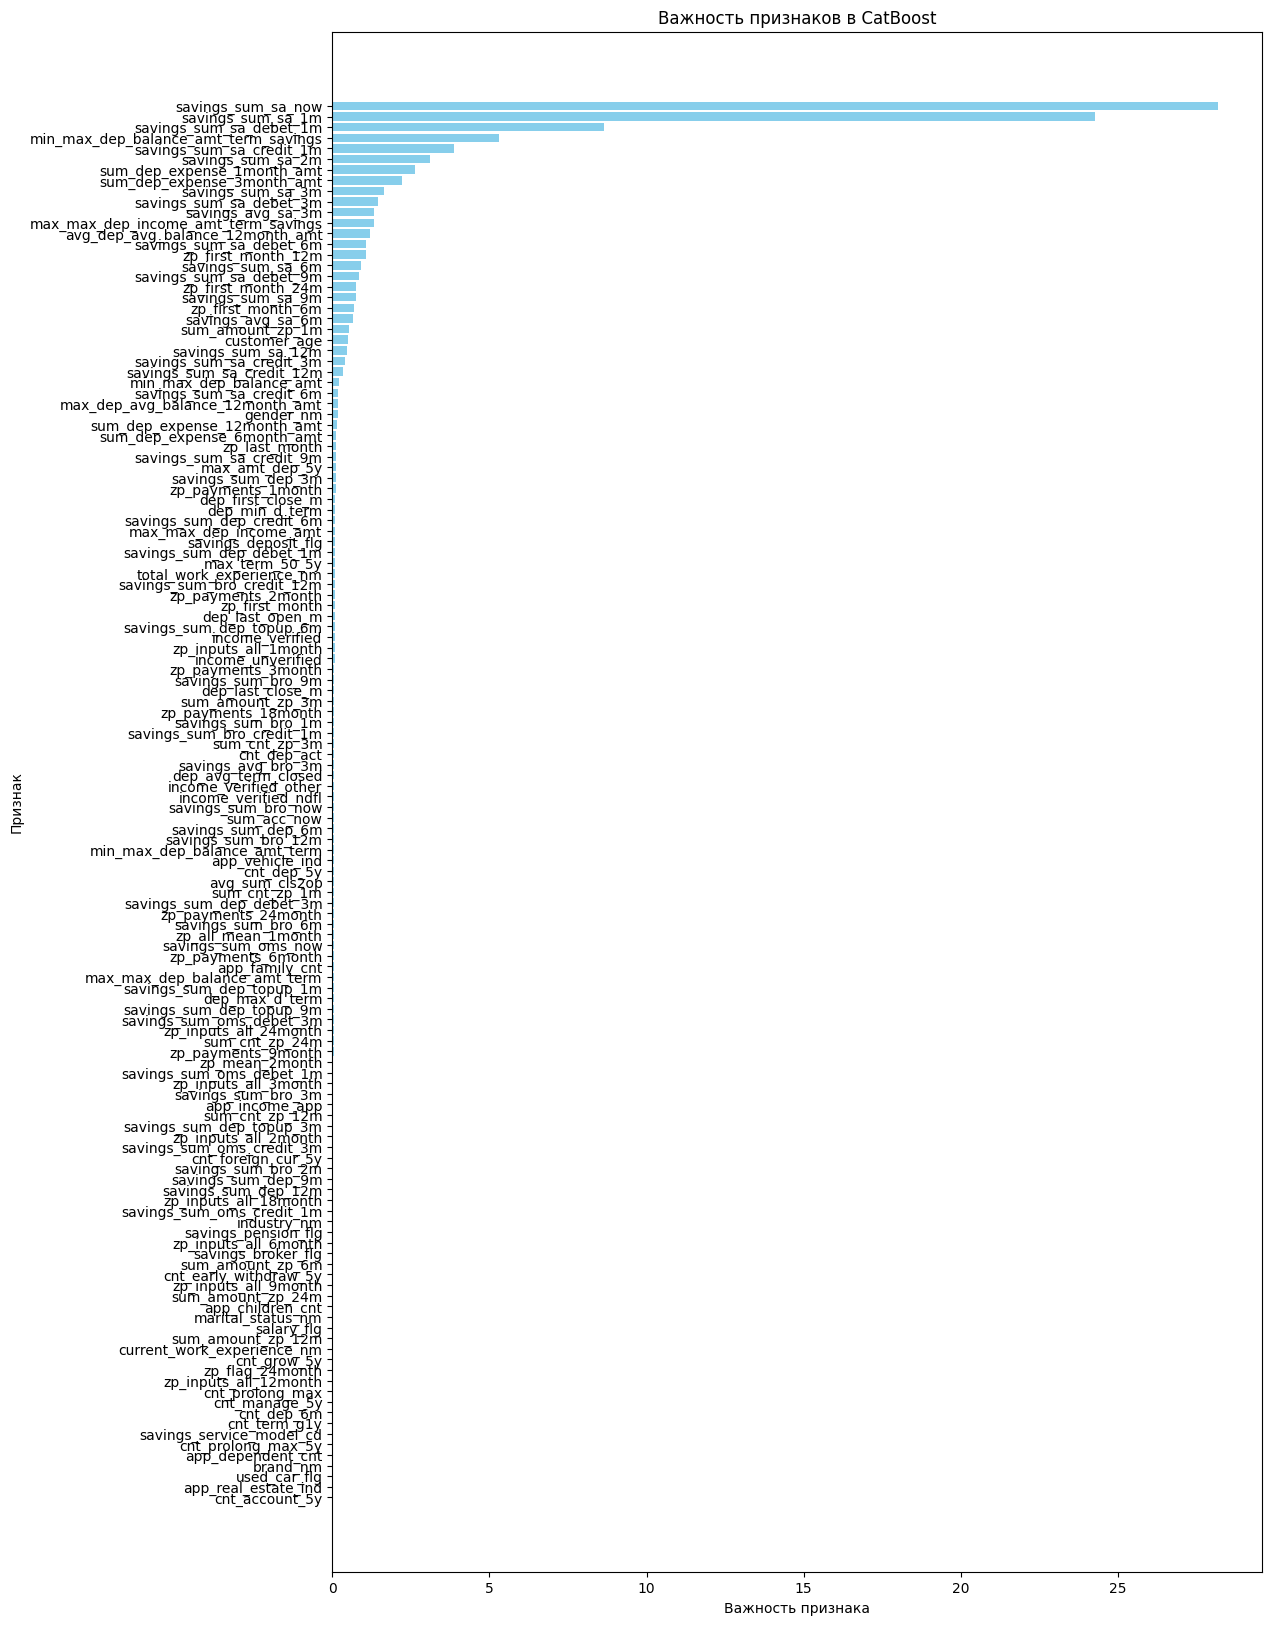

In [261]:
# Визуализация ненулевых по важности 

plt.figure(figsize=(12, 20))
plt.barh(selected_features['Feature'], selected_features['Importance'], color='skyblue')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в CatBoost')
plt.gca().invert_yaxis()  # Самые важные признаки сверху

experiment.log_figure(figure=plt)
plt.show()


In [262]:
# оставим только список из selected_features
selected_features_list = selected_features['Feature'].tolist()

In [263]:
# проверим , нет ли в категориальных отсеченных признаков
display(len(categorical_features_full))

categorical_features_full = [feature for feature in categorical_features_full if feature in selected_features_list]

display(len(categorical_features_full))

22

15

#### **4. Разделение данных**  
- **Train/Test Split**:  
  ```python
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  ``` 

In [264]:
# Финальная проверка всех категориальных признаков
for col in categorical_features_full:
    print(f"\nПроверка колонки {col}:")
    print("Тип данных:", train[col].dtype)
    print("Уникальные значения:", train[col].unique()[:5])
    print("Количество пропусков:", train[col].isna().sum())


Проверка колонки brand_nm:
Тип данных: object
Уникальные значения: ['MISSING' 'LAND ROVER' 'MITSUBISHI' 'ГАЗ' 'HYUNDAI']
Количество пропусков: 0

Проверка колонки salary_flg:
Тип данных: object
Уникальные значения: ['MISSING' 'SZP' 'IZP' 'OTHER']
Количество пропусков: 0

Проверка колонки total_work_experience_nm:
Тип данных: object
Уникальные значения: ['MISSING' '10+' '3-10' '1-3' '0-1']
Количество пропусков: 0

Проверка колонки savings_service_model_cd:
Тип данных: object
Уникальные значения: ['Массовый' 'Привилегия' 'VIP']
Количество пропусков: 0

Проверка колонки current_work_experience_nm:
Тип данных: object
Уникальные значения: ['MISSING' '12м+' '0-3м' '6-12м' '3-6м']
Количество пропусков: 0

Проверка колонки app_real_estate_ind:
Тип данных: object
Уникальные значения: ['MISSING' '0.0' '1.0']
Количество пропусков: 0

Проверка колонки gender_nm:
Тип данных: object
Уникальные значения: ['Ж' 'М' '?']
Количество пропусков: 0

Проверка колонки marital_status_nm:
Тип данных: object
Ун

In [265]:

X_train, X_test, y_train, y_test = model_selection.train_test_split(train[selected_features_list], np.log1p(y_train_df['target']), test_size=0.2, random_state=42)


#### **5. Оптимизация гиперпараметров (Optuna)**  

In [266]:


# Функция для оптимизации (минимизация RMSE)
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'depth': trial.suggest_int('depth', 6, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 5, log=True),
        'border_count': trial.suggest_categorical('border_count', [64, 128, 254]),
        'random_strength': trial.suggest_float('random_strength', 0.5, 5),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 2.0),
        'grow_policy': 'Depthwise',
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'loss_function': 'RMSE',
        'verbose': False,
        'random_seed': 42,
        'nan_mode': 'Min',
        'task_type': 'GPU',
        'devices': 'all',
        #'bootstrap_type': 'Poisson',
        'max_ctr_complexity': 4
    }
    
    # Инициализация кросс-валидации
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        # Разделение данных на train/val для текущего фолда
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Создание Pool для текущего фолда
        train_pool = Pool(
            data=X_tr,
            label=y_tr,
            cat_features=categorical_features_full,
            feature_names=list(X_train.columns))
        
        val_pool = Pool(
            data=X_val,
            label=y_val,
            cat_features=categorical_features_full,
            feature_names=list(X_train.columns))
        

        
        # Обучение модели
        model = CatBoostRegressor(**params)
        model.fit(
            train_pool,
            eval_set=val_pool,
            early_stopping_rounds=50,
            verbose=0
        )
        
        # Предсказание и расчет RMSE для фолда
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_scores.append(rmse)
    
    # Возвращаем средний RMSE по всем фолдам
    return np.mean(rmse_scores)

# Запуск Optuna (direction='minimize' для RMSE)
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=20),
    pruner=optuna.pruners.HyperbandPruner()
)
'''
# Запуск оптимизации (25 trials)
study.optimize(objective, n_trials=25, show_progress_bar=True)

# Лучшие параметры
print("Best trial:")
trial = study.best_trial
print(f"  Mean CV RMSE: {trial.value:.10f}")
print("  Best params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
'''

[I 2025-04-02 18:08:59,814] A new study created in memory with name: no-name-576efa6d-edae-4d05-9275-75e2e46dc425


'\n# Запуск оптимизации (25 trials)\nstudy.optimize(objective, n_trials=25, show_progress_bar=True)\n\n# Лучшие параметры\nprint("Best trial:")\ntrial = study.best_trial\nprint(f"  Mean CV RMSE: {trial.value:.10f}")\nprint("  Best params:")\nfor key, value in trial.params.items():\n    print(f"    {key}: {value}")\n'

In [267]:
# Загружаем параметры из JSON-файла
with open('optuna_params.json', 'r') as f:
    best_params = json.load(f)

print(best_params)  # Выводим загруженные параметры

{'iterations': 1309, 'learning_rate': 0.018892308248463628, 'depth': 8, 'l2_leaf_reg': 4.877741075696445, 'border_count': 254, 'random_strength': 1.7959852822676137, 'bagging_temperature': 1.6538466500791686, 'min_data_in_leaf': 1}


In [268]:

    
# Финальное обучение на всех данных с лучшими параметрами
best_model = CatBoostRegressor( **best_params, task_type = 'GPU', devices = 'all') # , bootstrap_type = 'Poisson', max_ctr_complexity = 4
best_model.fit(
    Pool(X_train, y_train, cat_features=categorical_features_full),
    verbose=False
)

# Оценка на тестовом наборе
test_preds = best_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
print(f"\nFinal Test RMSE: {final_rmse:.6f}")


Final Test RMSE: 2.106666


In [269]:
#hyper_params = trial.params
#with open('optuna_params.json', 'w') as f:
#    json.dump(hyper_params, f, indent=4) 
#experiment.log_parameters(hyper_params)

In [270]:
# Оценка на тестовом наборе
test_preds = best_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
print(f"\nFinal Test RMSE: {final_rmse:.6f}")


Final Test RMSE: 2.106666


In [271]:
metrics1 = {"RMSE":final_rmse}
experiment.add_tag("v2-scaled-features")
experiment.log_metrics(metrics1)
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/andreyshveduke/dsc-2025-3-distribution-task/c7caecde6311477fa15f59e3573d2071
COMET INFO:   Metrics:
COMET INFO:     RMSE : 2.1066661299467677
COMET INFO:   Parameters:
COMET INFO:     copy           : True
COMET INFO:     quantile_range : (25.0, 75.0)
COMET INFO:     unit_variance  : False
COMET INFO:     with_centering : False
COMET INFO:     with_scaling   : True
COMET INFO:   Uploads:
COMET INFO:     figures : 1
COMET INFO: 
COMET INFO: Uploading 18 metrics, params and output messages


Best trial:

Mean CV RMSE: 2.0937

Best params:

iterations: 1011

learning_rate: 0.02712733664191487

depth: 10

l2_leaf_reg: 2.3329885019744303

border_count: 254

random_strength: 2.9984036521975805

bagging_temperature: 1.2944758675340098

min_data_in_leaf: 13


Final Test RMSE: 2.0934

Best params:

    iterations: 801

    learning_rate: 0.020163739701165504

    depth: 10

    l2_leaf_reg: 4.593835786771801

    border_count: 254

    random_strength: 4.869378131413066

    bagging_temperature: 1.720647907124628

    min_data_in_leaf: 19


    Final Test RMSE: 2.1204


### Предобработка test_data

In [272]:
test = pd.read_parquet('data/test_main.parquet')

In [273]:
# рассмотрим категории , которые в основном Df не имеют таких признаков , т е определяются как int64

categorical_features_list = cat_features(test)

cat_indict = dict_main[dict_main['modeling_type'] == 'categorical']['feature'].tolist()

cat_indict = [x for x in cat_indict if x not in categorical_features_list]


In [274]:
# удалим столбцы с пропусками с заданным порогом
drop_list = drop_null(test, 70)

test = test.drop(columns = drop_list)


vehicle_counrty_type_nm                      97.210874
max_amt_foreign_cur_5y                       95.328010
min_amt_term_g1y                             86.884638
max_amt_dep_6m                               80.326958
max_amt_dep_act                              78.676782
avg_sum_nws2op                               78.645066
dep_avg_term_active                          78.594823
avg_dep_avg_balance_fact_1month_amt_term     77.946058
avg_dep_avg_balance_fact_3month_amt_term     76.773193
avg_dep_avg_balance_fact_6month_amt_term     75.437351
zp_flag_2month                               74.576622
avg_dep_avg_balance_fact_12month_amt_term    73.586517
zp_flag_3month                               70.212058
dtype: float64

In [275]:
categorical_features_full = full_catlist(test, dict_main)


In [276]:
test = fill_cat_nan(test, categorical_features_full)

In [277]:
# c таблицей train из за уникальности категории brand_nm принял решение отработать ее отдельно 
test = replace_rare_categories(test, categorical_features_full, threshold=0.001, replace_with='OTHER', exception = ['industry_nm', 'gender_nm', 'marital_status_nm', 'brand_nm'])

In [278]:
# обработаем brand_nm

brand_counts = test['brand_nm'].value_counts()

popular_brands = brand_counts[brand_counts > 2].index

test['brand_nm'] = test['brand_nm'].apply(lambda x: x if x in popular_brands else 'OTHER')


In [279]:
#отсечем категории и index_id

#copy_df =  only_numeric(test, categorical_features_full)
#numeric_cols = copy_df.columns.tolist()


In [280]:
constant_cols, test = del_constant_columns(test)

# обновляем списки numeric_cols, categorical_features_full !!!!!!!
categorical_features_full = [ cat for cat in categorical_features_full if cat not in constant_cols]
train[categorical_features_full] = train[categorical_features_full].astype(str)
copy_df =  only_numeric(test, categorical_features_full)
numeric_cols = copy_df.columns.tolist()

['savings_safe_acc_flg']

In [281]:
find_all_duplicates(test)

Дубликатов не найдено


In [282]:


# Масштабируем каждую колонку отдельно
for col in set(selected_features_list) & set(simple_cols + complex_cols):
    # Получаем колонку и создаем маску не-NaN значений
    col_data = test[col].values.reshape(-1, 1)
    mask = ~pd.isna(col_data).flatten()  # Маска для не-NaN значений
    
    # Масштабируем только не-NaN значения
    if sum(mask) > 0:  # Если есть что масштабировать
        test.loc[mask, col] = scaler.transform(col_data[mask]).flatten()

In [283]:
test[selected_features_list]

,savings_sum_sa_now,savings_sum_sa_1m,savings_sum_sa_debet_1m,min_max_dep_balance_amt_term_savings,savings_sum_sa_credit_1m,savings_sum_sa_2m,sum_dep_expense_1month_amt,sum_dep_expense_3month_amt,savings_sum_sa_3m,savings_sum_sa_debet_3m,...,cnt_manage_5y,cnt_dep_6m,cnt_term_g1y,savings_service_model_cd,cnt_prolong_max_5y,app_dependent_cnt,brand_nm,used_car_flg,app_real_estate_ind,cnt_account_5y
0,46.158264,46.149655,0.189792,4.594369e+01,0.396709,45.945998,0.000000,1.196398,46.154629,0.605117,...,0.0,0.000000,0.000092,Массовый,0.0,NaN,MISSING,MISSING,MISSING,0.0
1,0.000000,0.000000,0.000000,NaN,0.000000,0.020731,NaN,NaN,0.000000,0.010515,...,0.0,0.000000,0.000000,Массовый,NaN,NaN,MISSING,0.0,0.0,0.0
2,0.023192,0.000000,0.000000,4.594436e-07,0.000000,0.000000,18.143745,88.625301,0.001111,0.034528,...,0.0,0.000000,0.000000,Массовый,NaN,0.0,MISSING,0.0,0.0,0.0
3,7.722325,1.308798,10.236682,4.594436e-07,17.979428,7.226066,35.830281,101.259002,0.021915,30.790787,...,0.0,0.000000,0.000000,Массовый,NaN,NaN,MISSING,0.0,0.0,0.0
4,0.010211,0.000000,0.000000,5.265648e-02,0.000000,0.000000,0.126676,0.000000,0.000000,0.018727,...,0.0,0.000000,0.000000,Массовый,NaN,NaN,MISSING,MISSING,MISSING,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318446,50.253326,62.867242,13.974627,4.038948e-01,1.290496,62.469783,94.704475,369.116886,0.449289,14.406980,...,1.0,0.000046,0.000046,Привилегия,1.0,0.0,MISSING,0.0,0.0,0.0
318447,0.000000,0.000000,0.000000,4.594436e-07,0.000000,0.007720,NaN,NaN,0.000354,0.029213,...,0.0,0.000000,0.000000,Массовый,NaN,NaN,MISSING,0.0,0.0,0.0
318448,0.496363,0.505154,0.015656,4.594436e-07,0.015067,0.488876,NaN,0.000000,0.520032,0.005766,...,0.0,0.000000,0.000000,Массовый,NaN,NaN,MISSING,MISSING,MISSING,0.0
318449,0.000000,0.000000,0.000000,4.594436e-07,0.000000,0.010786,NaN,NaN,0.003032,0.001844,...,0.0,0.000000,0.000000,Массовый,NaN,0.0,MISSING,0.0,0.0,0.0


In [284]:
for col in categorical_features_full:
    test[col] = test[col].astype(str)

In [285]:
# Финальная проверка всех категориальных признаков
for col in categorical_features_full:
    print(f"\nПроверка колонки {col}:")
    print("Тип данных:", test[col].dtype)
    print("Уникальные значения:", test[col].unique()[:5])
    print("Количество пропусков:", test[col].isna().sum())


Проверка колонки brand_nm:
Тип данных: object
Уникальные значения: ['MISSING' 'AUDI' 'FORD' 'VOLVO' 'HYUNDAI']
Количество пропусков: 0

Проверка колонки salary_flg:
Тип данных: object
Уникальные значения: ['MISSING' 'SZP' 'OTHER' 'IZP']
Количество пропусков: 0

Проверка колонки total_work_experience_nm:
Тип данных: object
Уникальные значения: ['MISSING' '10+' '1-3' '3-10' '0-1']
Количество пропусков: 0

Проверка колонки zp_flag_9month:
Тип данных: object
Уникальные значения: ['MISSING' '1.0']
Количество пропусков: 0

Проверка колонки savings_service_model_cd:
Тип данных: object
Уникальные значения: ['Массовый' 'Привилегия' 'VIP']
Количество пропусков: 0

Проверка колонки current_work_experience_nm:
Тип данных: object
Уникальные значения: ['MISSING' '12м+' '3-6м' '6-12м' '0-3м']
Количество пропусков: 0

Проверка колонки app_real_estate_ind:
Тип данных: object
Уникальные значения: ['MISSING' '0.0' '1.0']
Количество пропусков: 0

Проверка колонки zp_flag_18month:
Тип данных: object
Уника

In [286]:
X_test = test[selected_features_list]

In [287]:
# Предсказания на тесте
test_preds = best_model.predict(X_test)

In [288]:
sample = pd.read_csv('data/sample_submit_naive.csv')
sample

,user_id,predict
0,1000008,1.004656e+06
1,1000009,0.000000e+00
2,1000013,5.047758e+02
3,1000016,1.680799e+05
4,1000017,2.222542e+02
...,...,...
318446,2499983,1.093786e+06
318447,2499984,0.000000e+00
318448,2499989,1.080357e+04
318449,2499991,0.000000e+00


In [289]:
# Проверка построчного совпадения (если индексы одинаковы)
if (sample['user_id'] == test['user_id']).all():
    print("Все строки в user_id совпадают")
else:
    print("Есть различия в строках")
    
    # Поиск строк с различиями
    diff_mask = sample['user_id'] != test['user_id']
    differences = pd.DataFrame({
        'sample': sample.loc[diff_mask, 'user_id'],
        'X_test': test.loc[diff_mask, 'user_id']
    })
    print("Различающиеся строки:")
    print(differences)

Все строки в user_id совпадают


In [290]:
test_full_predict = np.exp(test_preds) - 1

In [291]:
sample['predict'] = test_full_predict

In [292]:
sample

,user_id,predict
0,1000008,5.210116e+06
1,1000009,9.495432e+00
2,1000013,8.430248e+01
3,1000016,2.905828e+04
4,1000017,8.830222e+01
...,...,...
318446,2499983,3.028407e+06
318447,2499984,5.391911e+00
318448,2499989,7.945518e+04
318449,2499991,1.276378e+01


In [293]:
sample.to_csv('shved_submit_2.csv', index=False)